In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import importlib
from joblib import Parallel, delayed, cpu_count

%matplotlib ipympl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
# plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

In [2]:
GHz = 1e9
nH = 1e-9
fF = 1e-15
h    = 6.626e-34
e0   = 1.602e-19
Φ_0 = h/(2*e0)

# Experimental parameters for the actual qubits

In [13]:
L_F_eff_1 = 26.5
L_F_eff_2 = 20.4
L_F_eff_3 = 32.2

C_F_eff_1 = 26.9
C_F_eff_2 = 22.4
C_F_eff_3 = 24.8

EJ_1 = 5.4
EJ_2 = 9.5
EJ_3 = 5.6

E_L_1 = sq_ext.L_to_EL(L_F_eff_1)
E_L_2 = sq_ext.L_to_EL(L_F_eff_2)
E_L_3 = sq_ext.L_to_EL(L_F_eff_3)

E_C_1 = sq_ext.C_to_EC(C_F_eff_1)
E_C_2 = sq_ext.C_to_EC(C_F_eff_2)
E_C_3 = sq_ext.C_to_EC(C_F_eff_3)

experiment_coords = [ (EJ_1/E_L_1, E_C_1/E_L_1),
                      (EJ_2/E_L_2, E_C_2/E_L_2),
                      (EJ_3/E_L_3, E_C_3/E_L_3)]

omega_q_exp = [3.7001944890642844, 3.4505095260121497, 3.0342472605322786]
experiment_colors = ['b', 'g', 'r']
ω_r_exp = [6.46, 6.274, 5.22] 

# $\omega_{01}^-$ vs experimental parameters

In [6]:
n_plot              = 40
EJ_by_EL_F_values   = np.linspace(0.01,2,n_plot)
EC_F_by_EL_F_values = np.linspace(0.05, 0.2,n_plot+3)

In [7]:
def gap_vs_EJ_EC(EJ_by_EL_F, EC_F_by_EL_F_values):
    ω01_by_EL_F_vs_params = np.zeros([len(EC_F_by_EL_F_values)])
    ω12_by_EL_F_vs_params = np.zeros([len(EC_F_by_EL_F_values)])

    for j, EC_F_by_EL_F in enumerate(EC_F_by_EL_F_values):
        fluxonium = sq_ext.sq_fluxonium(EJ=EJ_by_EL_F, E_C=EC_F_by_EL_F, E_L=1)
        fluxonium.diag(3)
        ω01_by_EL_F_vs_params[j] = fluxonium.efreqs[1] - fluxonium.efreqs[0]
        ω12_by_EL_F_vs_params[j] = fluxonium.efreqs[2] - fluxonium.efreqs[1]

    return ω01_by_EL_F_vs_params, ω12_by_EL_F_vs_params

In [8]:
Data = Parallel(n_jobs=min(cpu_count(), n_plot))(delayed(gap_vs_EJ_EC)(EJ_by_EL_F, EC_F_by_EL_F_values) for EJ_by_EL_F in EJ_by_EL_F_values)

In [9]:
ω01_by_EL_F_vs_params = []
ω12_by_EL_F_vs_params = []
for i, (Data_i) in enumerate(zip(Data)):
    ω01, ω12 = Data_i[0]
    ω01_by_EL_F_vs_params.append(ω01)
    ω12_by_EL_F_vs_params.append(ω12)

ω01_by_EL_F_vs_params = np.array(ω01_by_EL_F_vs_params).T
ω12_by_EL_F_vs_params = np.array(ω12_by_EL_F_vs_params).T

# Gap and anh

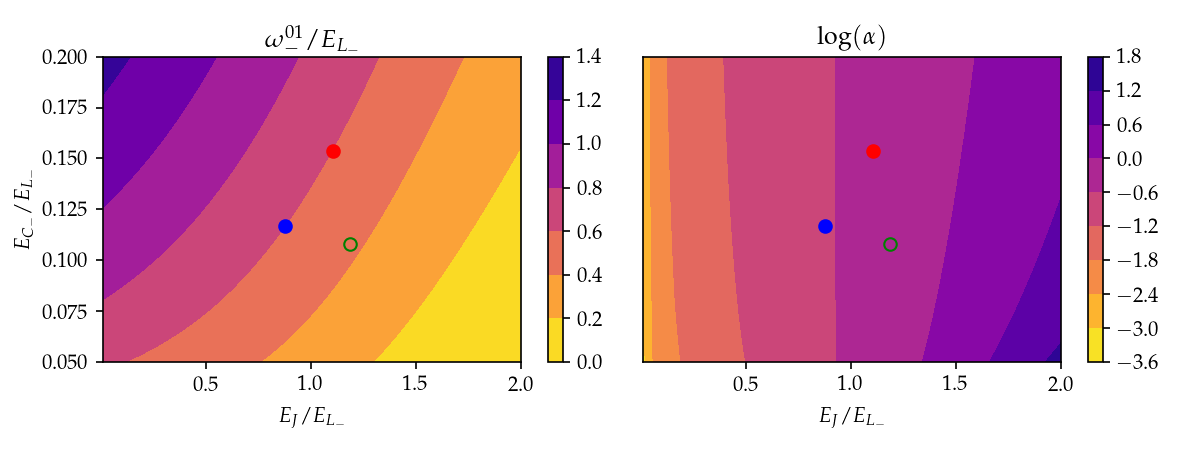

In [11]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=[8,3],dpi=150)
x = EJ_by_EL_F_values   
y = EC_F_by_EL_F_values 

ω = ω01_by_EL_F_vs_params
contour_plot = ax1.contourf(x, y, ω, levels=7, cmap='plasma_r') 
cb = fig.colorbar(contour_plot)
ax1.set_title(r'$\omega^{01}_-/E_{L_-}$')
ax1.set_xlabel('$E_J/E_{L_-}$')
ax1.set_ylabel('$E_{C_-}/E_{L_-}$')


α = np.log10(ω12_by_EL_F_vs_params / ω01_by_EL_F_vs_params - 1)
contour_plot = ax2.contourf(x, y, α, levels=7, cmap='plasma_r') 
cb = fig.colorbar(contour_plot)
ax2.set_title(r'$\log(\alpha)$')
ax2.set_yticks([])
ax2.set_xlabel('$E_J/E_{L_-}$')

for ax in [ax1,ax2]:
    for i, (EJ_by_EL_exp, EC_by_EL_exp) in enumerate(experiment_coords):
        if i == 1:
            ax.plot(EJ_by_EL_exp, EC_by_EL_exp, 'o', color=experiment_colors[i], markerfacecolor='none')
        else:
            ax.plot(EJ_by_EL_exp, EC_by_EL_exp, 'o', color=experiment_colors[i])

fig.tight_layout()
fig.show()
figs.export('gap_and_anh_by_EL_vs_EC_EJ_by_EL.pdf', fig=fig)

# Spectrum

In [14]:
n_plot = 51
φ_ext_values = np.linspace(0.5, 1, n_plot)

def E_vs_φ_ext(φ_ext, EJ, EC, EL):
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, E_C=EC, E_L=EL, φ_ext=φ_ext)
    fluxonium.diag(4)
    E = fluxonium.efreqs-fluxonium.efreqs[0]
    return E

E_vs_φ_ext_1 = np.array(Parallel(n_jobs=min(cpu_count(), n_plot))( delayed(E_vs_φ_ext)(φ_ext, EJ_1, E_C_1, E_L_1) for φ_ext in φ_ext_values))
E_vs_φ_ext_2 = np.array(Parallel(n_jobs=min(cpu_count(), n_plot))( delayed(E_vs_φ_ext)(φ_ext, EJ_2, E_C_2, E_L_2) for φ_ext in φ_ext_values))
E_vs_φ_ext_3 = np.array(Parallel(n_jobs=min(cpu_count(), n_plot))( delayed(E_vs_φ_ext)(φ_ext, EJ_3, E_C_3, E_L_3) for φ_ext in φ_ext_values))

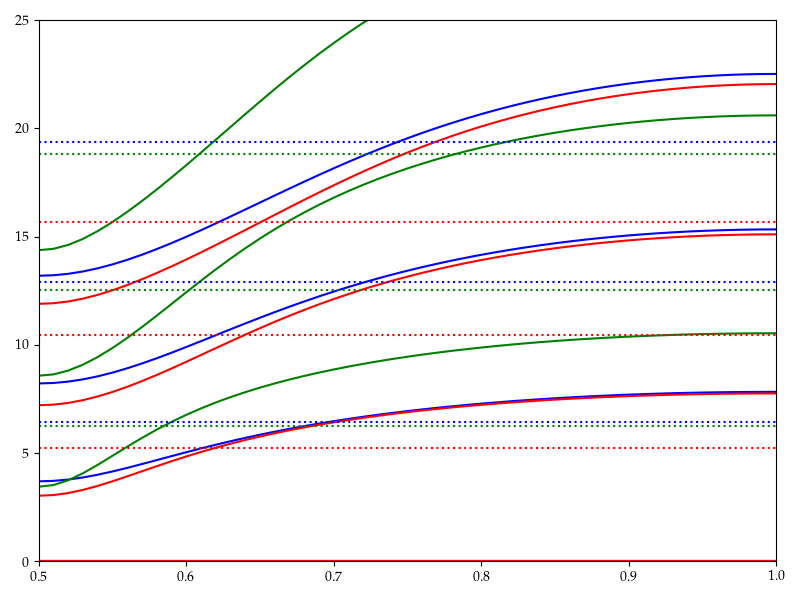

In [18]:
fig, ax = plt.subplots(figsize=[8,6])
[ax.plot(φ_ext_values, E_vs_φ_ext, color=experiment_colors[i]) for i, E_vs_φ_ext in enumerate([E_vs_φ_ext_1, E_vs_φ_ext_2, E_vs_φ_ext_3]) ]
[ax.hlines(ω_r, φ_ext_values.min(), φ_ext_values.max(), linestyle=':', color=experiment_colors[i]) for i, ω_r in enumerate(ω_r_exp) ]
[ax.hlines(2*ω_r, φ_ext_values.min(), φ_ext_values.max(), linestyle=':', color=experiment_colors[i]) for i, ω_r in enumerate(ω_r_exp) ]
[ax.hlines(3*ω_r, φ_ext_values.min(), φ_ext_values.max(), linestyle=':', color=experiment_colors[i]) for i, ω_r in enumerate(ω_r_exp) ]
#ax.set_ylabel(r'$')
#ax.set_xlabel(r'$')
#ax.set_title(r'$')
ax.set_ylim([0,25])
ax.set_xlim([0.5,1])
fig.tight_layout()
fig.show()

In [25]:
resonator = sq_ext.sq_resonator(L_R_eff=1,C_R_eff=2)
# resonator = sq_ext.sq_resonator(L_R_eff=2,C_R_eff=1)
resonator.diag(2)
resonator.efreqs[1]- resonator.efreqs[0]
resonator.flux_op(0)[0,1]

(18.803015465429617+0j)

In [24]:
# # Potentially useless
# def gap_vs_EJ(EJ_by_EL_F, EC_F_by_EL_F_values, EL_R_by_EL_F_values, EC_R_by_EL_F_values, Δ_by_Lq_values):
#     ω01_vs_params   = np.zeros([len(EC_F_by_EL_F_values)])
#     ω12_vs_params   = np.zeros([len(EC_F_by_EL_F_values)])
#     ω_r_vs_params   = np.zeros([len(EL_R_by_EL_F_values), len(EC_R_by_EL_F_values) ])
#     ω01_q_vs_params = np.zeros([len(EC_F_by_EL_F_values), len(EL_R_by_EL_F_values), len(EC_R_by_EL_F_values), len(Δ_by_Lq_values)  ])
#     ω12_q_vs_params = np.zeros([len(EC_F_by_EL_F_values), len(EL_R_by_EL_F_values), len(EC_R_by_EL_F_values), len(Δ_by_Lq_values)  ])
#     g_vs_params     = np.zeros([len(EC_F_by_EL_F_values), len(EL_R_by_EL_F_values), len(EC_R_by_EL_F_values), len(Δ_by_Lq_values) ])
#     
#     for j, EC_F_by_EL_F in enumerate(EC_F_by_EL_F_values):    
#         fluxonium = sq_ext.sq_fluxonium(EJ=EJ_by_EL_F, E_C=EC_F_by_EL_F, E_L=1)  
#         fluxonium.diag(3) 
#         ω01_vs_params[j] = fluxonium.efreqs[1]-fluxonium.efreqs[0]
#         ω12_vs_params[j] = fluxonium.efreqs[2]-fluxonium.efreqs[1]
#         
#         for k, EL_R_by_EL_F  in enumerate(EL_R_by_EL_F_values):
#             for l, EC_R_by_EL_F in enumerate(EC_R_by_EL_F_values):
#                 
#                 if j == 0:
#                     resonator = sq_ext.sq_resonator(E_C=EC_R_by_EL_F, E_L=EL_R_by_EL_F)
#                     resonator.diag(2) 
#                     ω_r_vs_params[k,l] = resonator.efreqs[1]-resonator.efreqs[0]
#             
#                 for m, Δ_by_Lq in enumerate(Δ_by_Lq_values):
# 
#                     E_q = sq_ext.diag(sq_ext.hamiltonian_qubit(fluxonium=fluxonium, resonator=resonator, Δ=Δ_by_Lq))[0]
#                     ω01_q_vs_params[j,k,l,m] = E_q[1]-E_q[0]
#                     ω12_q_vs_params[j,k,l,m] = E_q[2]-E_q[1]
#                     
#                     Φf = fluxonium.flux_op(0, basis='eig')[0,1]
#                     Φr = resonator.flux_op(0, basis='eig')[0,1]
#                     g_vs_params[j,k,l,m] =  2 * Δ_by_Lq * Φf * Φr * ( (2*np.pi)/Φ_0 )**2 * nH * GHz * h 
#                     
#     return ω01_vs_params, ω12_vs_params, ω01_q_vs_params, ω12_q_vs_params, ω_r_vs_params, g_vs_params
#     
# Data = Parallel(n_jobs=min(cpu_count(), n_plot))(delayed(gap_vs_EJ)(EJ_by_EL_F, EC_F_by_EL_F_values, EL_R_by_EL_F_values, EC_R_by_EL_F_values, Δ_by_Lq_values) for EJ_by_EL_F in EJ_by_EL_F_values)
# ω01_vs_params   = []
# ω12_vs_params   = []
# ω01_q_vs_params = []
# ω12_q_vs_params = []
# g_vs_params     = []
# 
# for i, (Data_i) in enumerate(zip(Data)):
#     ω01, ω12, ω01_q, ω12_q, ω_r, g= Data_i[0]
#     ω01_vs_params  .append( ω01   )
#     ω12_vs_params  .append( ω12   )
#     ω01_q_vs_params.append( ω01_q )
#     ω12_q_vs_params.append( ω12_q )
#     if i == 0:
#         ω_r_vs_params = ω_r
#     g_vs_params    .append( g     )
# 
# ω01_vs_params  = np.array(ω01_vs_params  )
# ω12_vs_params  = np.array(ω12_vs_params  )
# ω01_q_vs_params= np.array(ω01_q_vs_params)
# ω12_q_vs_params= np.array(ω12_q_vs_params)
# # ω_r_vs_params  = np.array(ω_r_vs_params  )
# g_vs_params    = np.array(g_vs_params    )